# Experiment 2

Imports

In [95]:
import pm4py
from sklearn.metrics import confusion_matrix
from mppn.imports import *
from mppn.preprocessing import *
from mppn.pipeline import *
from mppn.baselines import *

## Simulation

### Petri Net

In [2]:
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils


In [3]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
net = PetriNet("new_petri_net")


In [5]:
transition_names= [ 
'File travel reques',
'Prepare Price Inquiry',
'Check Price Inquiry',
'Approve by director',
'Prepare Booking Proposal',
'Check Booking Proposal',
'Approve by manager',
]

In [6]:
places=[]
for i in range(7):
    p=PetriNet.Place(str(i))
    net.places.add(p)
    places.append(p)

In [7]:
transitions=[]
for i,tn in enumerate(transition_names):
    t=PetriNet.Transition(str(i),tn)
    net.transitions.add(t)
    transitions.append(t)

In [8]:
places

[0, 1, 2, 3, 4, 5, 6]

In [9]:
places,transitions

([0, 1, 2, 3, 4, 5, 6],
 [File travel reques,
  Prepare Price Inquiry,
  Check Price Inquiry,
  Approve by director,
  Prepare Booking Proposal,
  Check Booking Proposal,
  Approve by manager])

In [10]:
def add_arc_from_place(p,t):
    petri_utils.add_arc_from_to(places[p], transitions[t], net)
def add_arc_from_transition(t,p):
    petri_utils.add_arc_from_to(transitions[t],places[p], net)

for i in range(6):
    add_arc_from_place(i,i)
    add_arc_from_transition(i,i+1)
add_arc_from_place(3,6) 
add_arc_from_transition(6,4)
#add_arc_from_transition(0,6)
#add_arc_from_transition(0,6)

    

In [11]:
initial_marking=Marking()
initial_marking[places[0]]=1
#final_marking=Marking()
#final_marking[places[4]]=1
# final_marking[places[7]]=1

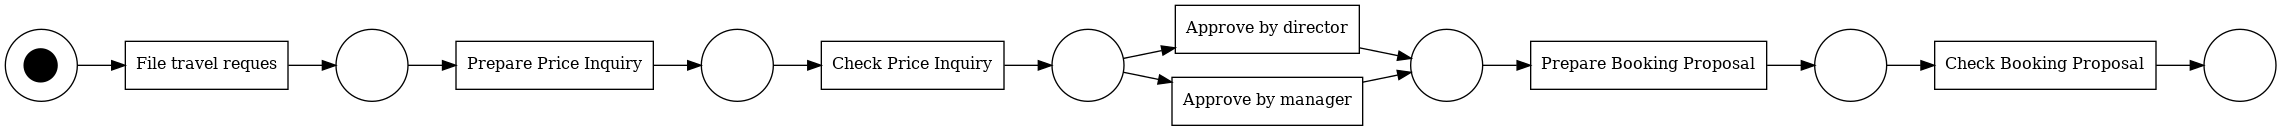

In [12]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking)
pn_visualizer.view(gviz)

In [13]:
parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, parameters=parameters)
pn_visualizer.save(gviz, "model_1.png")

### Reachability Graph

In [14]:

from pm4py.objects.petri_net.utils import reachability_graph

ts = reachability_graph.construct_reachability_graph(net, initial_marking)

In [15]:
nodes,transitions={},{}
for t in ts.transitions:
    if str(t.from_state) in nodes:
        nodes[str(t.from_state)].append(str(t.name))
    else: 
        nodes[str(t.from_state)]=[str(t.name)]
    
    transitions[f"{t.from_state}#{t.name}"]=str(t.to_state)
    print(t.name,t.from_state,t.to_state)

Check Price Inquiry 21 31
Check Booking Proposal 51 61
Prepare Booking Proposal 41 51
Prepare Price Inquiry 11 21
Approve by director 31 41
Approve by manager 31 41
File travel reques 01 11


In [16]:
nodes

{'21': ['Check Price Inquiry'],
 '51': ['Check Booking Proposal'],
 '41': ['Prepare Booking Proposal'],
 '11': ['Prepare Price Inquiry'],
 '31': ['Approve by director', 'Approve by manager'],
 '01': ['File travel reques']}

In [17]:
transitions

{'21#Check Price Inquiry': '31',
 '51#Check Booking Proposal': '61',
 '41#Prepare Booking Proposal': '51',
 '11#Prepare Price Inquiry': '21',
 '31#Approve by director': '41',
 '31#Approve by manager': '41',
 '01#File travel reques': '11'}

In [18]:
transitions['Start']=['01']
nodes['61']=[]

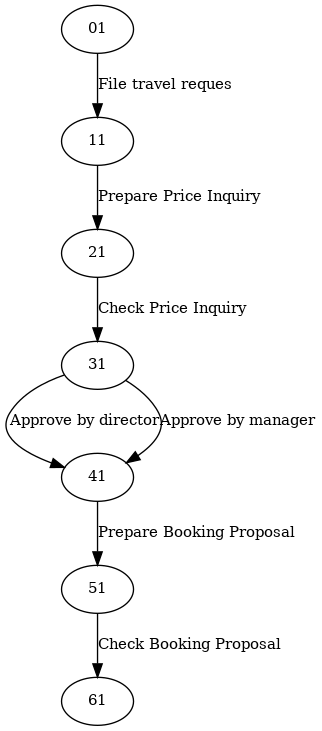

In [19]:
from pm4py.visualization.transition_system import visualizer as ts_visualizer

gviz = ts_visualizer.apply(ts)
ts_visualizer.view(gviz)

In [20]:
parameters = {ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT: "png"}
gviz = ts_visualizer.apply(ts, parameters=parameters)
pn_visualizer.save(gviz, "reach_graph_model_1.png")

### Log Simulation

In [21]:
%%time

from pm4py.algo.simulation.playout.petri_net import algorithm as simulator

simulated_log = simulator.apply(net, initial_marking, variant=simulator.Variants.BASIC_PLAYOUT, parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 100000})

CPU times: user 20.5 s, sys: 255 ms, total: 20.8 s
Wall time: 20.8 s


In [22]:
%%time
from pm4py.objects.conversion.log import converter as log_converter
df = log_converter.apply(simulated_log, variant=log_converter.Variants.TO_DATA_FRAME)

CPU times: user 2.35 s, sys: 121 ms, total: 2.47 s
Wall time: 2.47 s


In [23]:
df

,concept:name,time:timestamp,case:concept:name
0,File travel reques,1970-04-26 17:46:40,0
1,Prepare Price Inquiry,1970-04-26 17:46:41,0
2,Check Price Inquiry,1970-04-26 17:46:42,0
3,Approve by director,1970-04-26 17:46:43,0
4,Prepare Booking Proposal,1970-04-26 17:46:44,0
...,...,...,...
599995,Prepare Price Inquiry,1970-05-03 16:26:35,99999
599996,Check Price Inquiry,1970-05-03 16:26:36,99999
599997,Approve by director,1970-05-03 16:26:37,99999
599998,Prepare Booking Proposal,1970-05-03 16:26:38,99999


In [24]:
df.rename({'concept:name':'activity','case:concept:name':'trace_id','time:timestamp':'timestamp'},axis=1,inplace=True)

In [25]:
df.set_index('trace_id',inplace=True)

In [26]:
import pandas as pd

In [27]:
res=[]
for i,g in df.groupby(df.index):
    res.append([i,'Start'])
    for a in g['activity']:
        res.append([i,a])
df=pd.DataFrame(res,columns=['trace_id','activity'])
df

,trace_id,activity
0,0,Start
1,0,File travel reques
2,0,Prepare Price Inquiry
3,0,Check Price Inquiry
4,0,Approve by director
...,...,...
699995,99999,Prepare Price Inquiry
699996,99999,Check Price Inquiry
699997,99999,Approve by director
699998,99999,Prepare Booking Proposal


In [28]:
df.set_index('trace_id',inplace=True)

In [29]:
df['event_id']=df.groupby(df.index).cumcount()

In [30]:
df

,activity,event_id
trace_id,,
0,Start,0
0,File travel reques,1
0,Prepare Price Inquiry,2
0,Check Price Inquiry,3
0,Approve by director,4
...,...,...
99999,Prepare Price Inquiry,2
99999,Check Price Inquiry,3
99999,Approve by director,4


In [31]:
import numpy as np

In [32]:
cost = np.random.normal(loc=400,scale=350,size=len(df.index.unique())).round(2)
cost = cost.clip(0)
cost

array([327.31, 221.51, 592.24, ..., 512.8 , 641.22, 414.53])

In [165]:
trace_idTocost={i:j for i,j in zip(df.index.unique(),cost)}


In [34]:
df['cost']=pd.Series(trace_idTocost)[df.index]

In [35]:
df.head(20)

,activity,event_id,cost
trace_id,,,
0,Start,0,327.31
0,File travel reques,1,327.31
0,Prepare Price Inquiry,2,327.31
0,Check Price Inquiry,3,327.31
0,Approve by director,4,327.31
0,Prepare Booking Proposal,5,327.31
0,Check Booking Proposal,6,327.31
1,Start,0,221.51
1,File travel reques,1,221.51


In [36]:
df.loc[(df.cost >500) & (df.activity == 'Approve by manager'),'activity'] = 'Approve by director'


In [37]:
df.loc[(df.cost <=500) & (df.activity == 'Approve by director'),'activity'] = 'Approve by manager'


In [38]:
df.head()

,activity,event_id,cost
trace_id,,,
0,Start,0,327.31
0,File travel reques,1,327.31
0,Prepare Price Inquiry,2,327.31
0,Check Price Inquiry,3,327.31
0,Approve by manager,4,327.31


In [39]:
traces=df.groupby(df.index)['activity'].apply(lambda x:"->".join(list(x)))

traces

trace_id
0        Start->File travel reques->Prepare Price Inqui...
1        Start->File travel reques->Prepare Price Inqui...
10       Start->File travel reques->Prepare Price Inqui...
100      Start->File travel reques->Prepare Price Inqui...
1000     Start->File travel reques->Prepare Price Inqui...
                               ...                        
99995    Start->File travel reques->Prepare Price Inqui...
99996    Start->File travel reques->Prepare Price Inqui...
99997    Start->File travel reques->Prepare Price Inqui...
99998    Start->File travel reques->Prepare Price Inqui...
99999    Start->File travel reques->Prepare Price Inqui...
Name: activity, Length: 100000, dtype: object

In [40]:
df['traces']=traces

In [41]:
mean_costs = df.groupby('traces')['cost'].mean()

In [42]:
df['cost_gt500'] =  df['cost']>500

In [43]:
variants=df.groupby(['traces','cost_gt500']).size().reset_index()
variants

,traces,cost_gt500,0
0,Start->File travel reques->Prepare Price Inqui...,True,271012
1,Start->File travel reques->Prepare Price Inqui...,False,428988


In [44]:
variants['idx']= variants.index

## Deep Learning

In [73]:
splits = split_traces(df,validation_seed=42,test_seed=42)

In [74]:
o=PPObj(df,[Categorify(),Normalize()],cat_names=['activity'],cont_names=['cost'],y_names='activity',splits=splits)
o.show(max_n=2)
dls=o.get_dls(windows=partial(subsequences_fast,min_ws=0))
xcat,xcont,y=dls.one_batch()
xcat.shape,xcont.shape,y.shape

#traces: 100000 #events: 700000


,activity,cost
trace_id,,
68010,8,0.480728
68010,5,0.480728


(torch.Size([64, 6]), torch.Size([64, 6]), torch.Size([64]))

In [75]:
class Camargo_Concat(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        emb_dim_act = int(sqrt(vocab_act))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)

        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)
        self.lstm_concat= nn.LSTM(emb_dim_act+1, hidden, batch_first=True, num_layers=1)
        self.lstm_cost = nn.LSTM(1, hidden, batch_first=True, num_layers=1)
        self.linear_act = nn.Linear(2*hidden, vocab_act)
    def forward(self, xcat,xcont):
        x_act = self.emb_act(xcat)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
     
        
        x_cost,_ = self.lstm_cost(xcont[:,:,None])
        x_cost = x_cost[:,-1]
        
        x_concat=torch.cat((x_act, x_cost), 1)
      
        
        x_act = self.linear_act(x_concat)
        x_act = F.softmax(x_act,dim=1)
        return x_act

In [76]:
class SimpleRNN(nn.Module):
    def __init__(self, o,cuda=True):
        super().__init__()
        n_hidden = 25
        vocab_size=len(o.procs.categorify['activity'])
        n_fac = int(sqrt(vocab_size))+1
        self.is_cuda=cuda
        self.n_hidden=n_hidden
        self.e = nn.Embedding(vocab_size,n_fac)
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden,vocab_size)
        
    def forward(self, xb,xcont):
        cs=xb.permute(1,0)
        bs = len(cs[0])
        h = torch.zeros((bs,self.n_hidden))
        if self.is_cuda: h=h.cuda()
        for c in cs:
            inp = torch.relu(self.l_in(self.e(c)))
            h = torch.tanh(self.l_hidden(h+inp))
        return F.log_softmax(self.l_out(h),dim=0)

In [77]:
class Camargo_specialized(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        emb_dim_act = int(sqrt(vocab_act))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)

        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)
    def forward(self, xcat,xcont):
        x_act = self.emb_act(xcat)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        x_act = F.softmax(x_act,dim=1)

        return x_act

In [78]:
def fit_model1(inp,prediction,nodes,transitions,v):
    prefix = inp.tolist()
    start=False
    curNode='01'
    for i in prefix:
        a = v[i]
        if a == 'Start':
            start=True
            continue
        if start:
            if a not in nodes[curNode]:
                raise ValueError('Prefix should be correct')
            curNode=transitions['#'.join([curNode,a])]
    # check prediction

    p = v[prediction]
    if p not in nodes[curNode]:
        return False
    return True

def model_check1(inp,predictions,nodes,transitions,v):
    res=[]
    for i in range(len(inp)):
        res.append(fit_model1(inp[i],predictions[i],nodes,transitions,v))
    return res

def fit_model2(activities,costs,prediction,nodes,transitions,v):
    prefix = activities.tolist()
    start=False
    curNode='01'
    for i in prefix:
        a = v[i]
        if a == 'Start':
            start=True
            continue
        if start:
            if a not in nodes[curNode]:
                raise ValueError('Prefix should be correct')
            curNode=transitions['#'.join([curNode,a])]
    # check prediction

    p = v[prediction]
    if p not in nodes[curNode]:
        return False
    #print('??',costs[-1],p)
    if costs[-1] < 500 and p=='Approve by director':
        return False
    if costs[-1] > 500 and p=='Approve by manager':
        return False   
    return True

def model_check2(activities,costs,predictions,nodes,transitions,v):
    res=[]
    for i in range(len(activities)):
        res.append(fit_model2(activities[i],costs[i],predictions[i],nodes,transitions,v))
    return res


In [79]:
def plot_matrix_and_model_score(m,color="light:b"):
    m= m.cuda()

    p=m(dls.valid_ds.inp[0].cuda(),dls.valid_ds.inp[1].cuda())
    p=p.argmax(dim=1).cpu()



    y=dls.valid_ds.inp[2][0].cpu()


    def pct_cm(cm):
        m=np.zeros(cm.shape, dtype=float) 
        for i in range(len(cm[0])):
            summe=sum(cm[:,i])
            m[:,i]=(cm[:,i]/summe).round(2) if summe>0 else np.sign(cm[:,i].round(2))
        return(m)



    cm=confusion_matrix(y, p)
    pcm=cm
    #pcm=pct_cm(cm)

    o.categorify['activity'][y.unique().cpu().tolist()]

    vocab=o.categorify['activity'][y.unique().cpu().tolist()]



    cm_cols=o.categorify['activity'][np.unique(p.unique().cpu().tolist()+y.unique().cpu().tolist())]


    df_cm = pd.DataFrame(pcm, index = cm_cols,
                      columns = cm_cols)
    plt.figure(figsize = (7,7))
    sn.heatmap(df_cm, fmt='g',annot=True,cbar=False, cmap=sn.color_palette(color, as_cmap=True)
    )
    x=dls.valid_ds.inp[0].cpu().numpy()
    v=o.categorify['activity']
    res=model_check1(x,p,nodes,transitions,v)
    print('model_acc_1',sum(res)/len(res))
    mean, std = o.normalize.means['cost'],o.normalize.stds['cost']
    costs=dls.valid_ds.inp[1].cpu().numpy()
    costs = costs*std +mean
    res=model_check2(x,costs,p,nodes,transitions,v)
    print('model_acc_2',sum(res)/len(res))

### Simple RNN

epoch,train_loss,valid_loss,accuracy,time
0,0.298426,0.298628,0.896833,01:05
1,0.293598,0.298632,0.896833,01:05
2,0.308395,0.298633,0.896833,01:05
3,0.288286,0.298631,0.896833,01:06


Better model found at epoch 0 with valid_loss value: 0.2986283004283905.
No improvement since epoch 0: early stopping


Better model found at epoch 0 with valid_loss value: 0.897724986076355.
model_acc_1 1.0
model_acc_2 0.8968333333333334


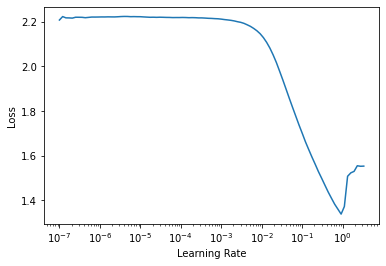

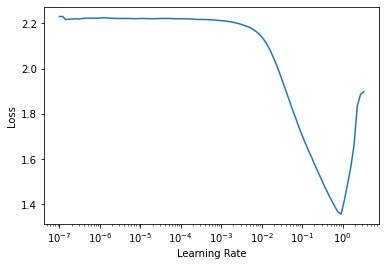

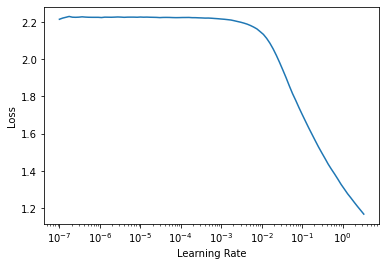

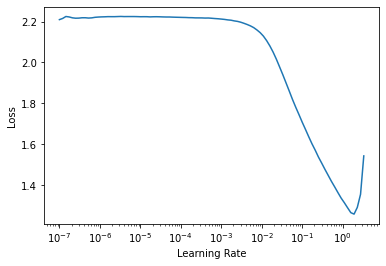

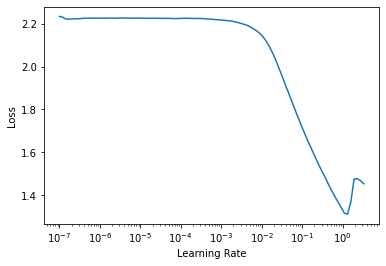

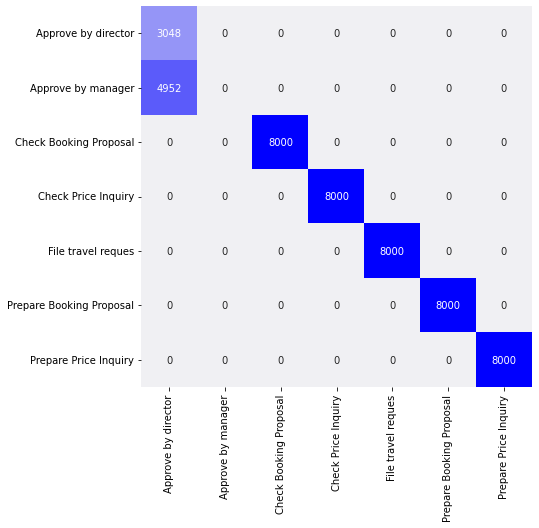

In [80]:
m1=SimpleRNN(o,True)
train_validate(dls,m1,loss=F.cross_entropy,metrics=accuracy,epoch=20,print_output=True)
plot_matrix_and_model_score(m1,color="light:b")

### Camargo Specialized

epoch,train_loss,valid_loss,accuracy,time
0,1.436440,1.435449,0.936500,01:00
1,1.432371,1.435449,0.936500,01:00
2,1.539199,1.530201,0.833333,00:59
3,2.211052,2.205282,0.166667,01:01


Better model found at epoch 0 with valid_loss value: 1.4354485273361206.
No improvement since epoch 0: early stopping


Better model found at epoch 0 with valid_loss value: 0.9356083273887634.
model_acc_1 1.0
model_acc_2 0.9365


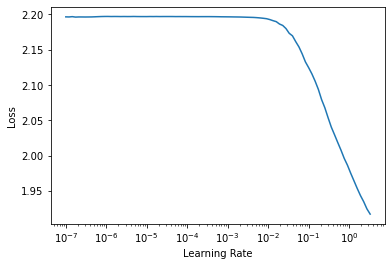

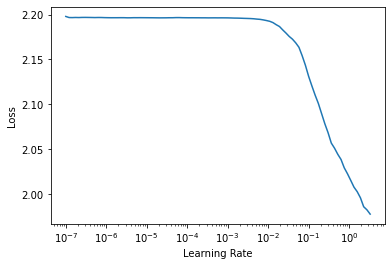

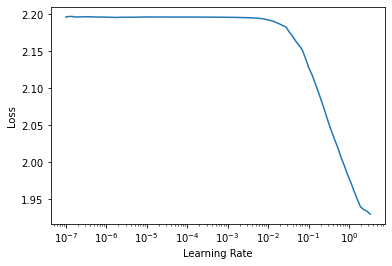

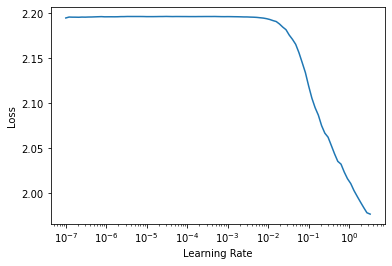

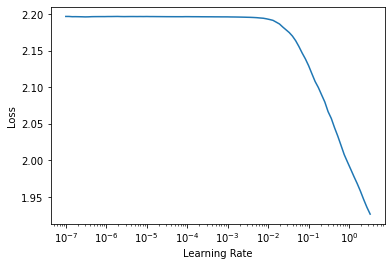

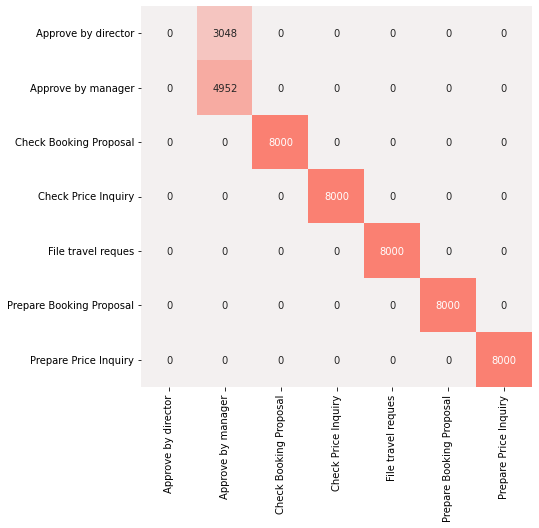

In [82]:
m2=Camargo_specialized(o)
train_validate(dls,m2,loss=F.cross_entropy,metrics=accuracy,epoch=20,print_output=True)
plot_matrix_and_model_score(m2,'light:salmon')

In [ ]:
m3=MPPN(o)
train_validate(dls,m3,loss=F.cross_entropy,metrics=accuracy,epoch=20,print_output=True)
plot_matrix_and_model_score(m3,'light:seagreen')

### MPPN

In [48]:
from mppn.mppn import *

In [49]:
def mppn_get_output_attributes(o):
    output_attributes = {i:len(o.procs.categorify[i]) for i in o.ycat_names }
    for i in o.ycont_names: output_attributes[i]=1
    return output_attributes

Loading Alexnet to train MPPNs CNN from scratch


epoch,train_loss,valid_loss,accuracy,time
0,0.005266,0.002024,0.999188,02:56
1,0.003771,0.001812,0.998917,02:58
2,0.004245,0.001041,0.999583,02:58
3,0.003211,0.015167,0.998354,02:56


Better model found at epoch 0 with valid_loss value: 0.0020243427716195583.
Better model found at epoch 1 with valid_loss value: 0.0018123299814760685.
Better model found at epoch 2 with valid_loss value: 0.001041233423165977.
No improvement since epoch 0: early stopping


Better model found at epoch 0 with valid_loss value: 0.9996833205223083.


0.9996833205223083

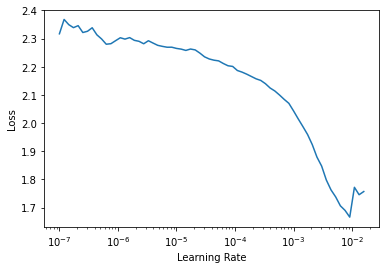

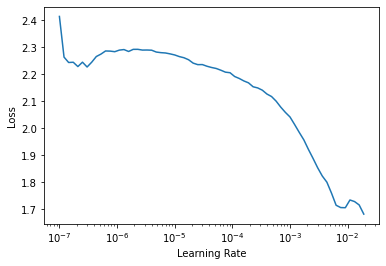

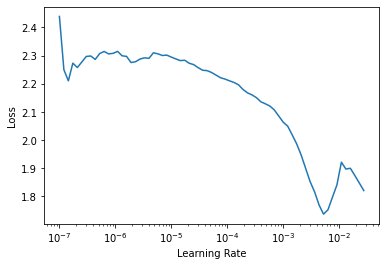

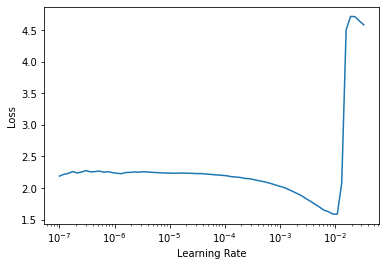

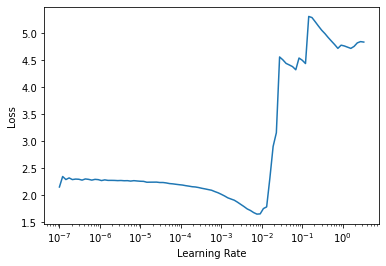

In [132]:
o=PPObj(df,[Categorify,Datetify,FillMissing,MinMax],
        cat_names=['activity'],cont_names=['cost'],
        splits=splits,y_names=['activity'])
output_attributes=mppn_get_output_attributes(o)
m3 = mppn_representation_learning_model(False, len(o.cont_names), output_attributes)
m3 = mppn_fine_tuning_model(m3, len(output_attributes), output_attributes[col])
col='activity'
dls=o.get_dls(after_batch=gaf_transform,windows=partial(subsequences_fast),bs=32)
train_validate(dls,m3,loss=F.cross_entropy,metrics=accuracy,epoch=20)

Calculate Confusion Matrix

<AxesSubplot:>

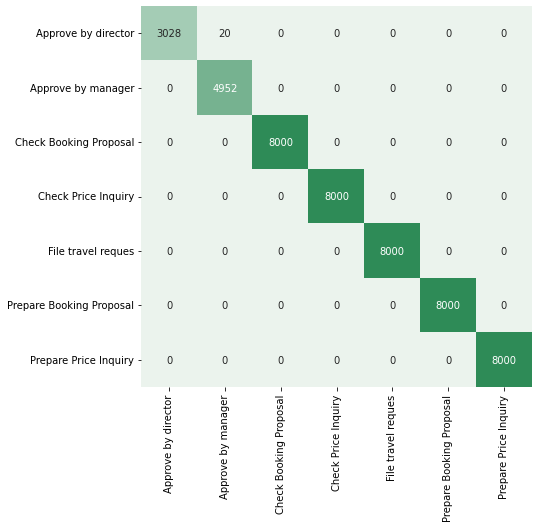

In [156]:

m =  m3.cuda()
ps,ys=[],[]
for b in dls.valid:  
    p=m(b[0].cuda())
    p=p.argmax(dim=1).cpu()
    y=b[1].cpu()
    ps+=p.tolist()
    ys+=y.tolist()
color= 'light:seagreen'
p,y =tensor(ps),tensor(ys)
cm=confusion_matrix(y, p)
pcm=cm
#pcm=pct_cm(cm)

o.categorify['activity'][y.unique().cpu().tolist()]

vocab=o.categorify['activity'][y.unique().cpu().tolist()]



cm_cols=o.categorify['activity'][np.unique(p.unique().cpu().tolist()+y.unique().cpu().tolist())]


df_cm = pd.DataFrame(pcm, index = cm_cols,
                  columns = cm_cols)
plt.figure(figsize = (7,7))
sn.heatmap(df_cm, fmt='g',annot=True,cbar=False, cmap=sn.color_palette(color, as_cmap=True)
)



Calculate Model scores
- Model 1 is without cost, only control-flow
- Model 2 is with cost

In [163]:
x=dls.valid_ds.inp[0][:,0].cpu().numpy()
minn, maxx = o.min_max.mins['activity'],o.min_max.maxs['activity']
x = x*(maxx-minn) +minn
x=x.astype(int)
v=o.categorify['activity']
res=model_check1(x,p,nodes,transitions,v)
print('model_acc_1',sum(res)/len(res))
minn, maxx = o.min_max.mins['cost'],o.min_max.maxs['cost']
costs=dls.valid_ds.inp[0][:,1].cpu().numpy()
costs = costs*(maxx-minn) +minn
res=model_check2(x,costs,p,nodes,transitions,v)
print('model_acc_2',sum(res)/len(res))

model_acc_1 1.0
model_acc_2 0.9995833333333334


In [164]:
inp = [
    [0.8968333333333334,0.896833],
    [0.9365,0.9365],
    [0.999583,0.9995833333333334],
]
print(pd.DataFrame(inp,columns=['Net-step Accuracy','Model Assessment'],index=['Simple RNN','Camargo Specialiced','MPPN']).round(3).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Net-step Accuracy &  Model Assessment \\
\midrule
Simple RNN          &              0.897 &             0.897 \\
Camargo Specialiced &              0.936 &             0.936 \\
MPPN                &              1.000 &             1.000 \\
\bottomrule
\end{tabular}

